# Phase 1 and Model Building

In [2]:
#Suppressing Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#Importing required Libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from PIL import Image
from os import walk
from skimage.filters import threshold_mean
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import walk
import random

In [4]:
#Hopfield network code from Github (https://github.com/DenseLance/hopfield-networks/tree/main)
import numpy as np
from PIL import Image
from typing import Optional

class ClassicalHopfield:
    """
    Based on the paper "Neural networks and physical systems with emergent collective computational abilities"
    by J. Hopfield, 1982.
    Link to paper: https://www.pnas.org/doi/10.1073/pnas.79.8.2554
    """
    def __init__(self, *, input_shape: tuple, threshold: Optional[np.ndarray] = None): # PIL.Image.size = (W, H), np.ndarray.shape = (H, W); use PIL for input_shape
        assert len(input_shape) == 2
        assert threshold is None or threshold.shape == (np.prod(input_shape),)

        self.input_shape = input_shape
        self.weight_shape = (np.prod(self.input_shape),) * 2
        self.weights = np.zeros(self.weight_shape)
        self.threshold = np.zeros(self.weight_shape[0]) if threshold is None else threshold # also known as bias

    def process_image(self, image: Image) -> np.ndarray:
        # assert image.size == self.input_shape

        states = np.asarray(image.convert("1"))  # converting to black and white image
        states = states * 2 - 1 # converting image to polar values of {-1, 1}
        states = states.flatten() # converting image to a singular axis

        return states

    def restore_image(self, states: np.ndarray) -> Image:
        image = states.reshape(self.input_shape[::-1]) # ensure restored image is in PIL format
        return image

    def storage_capacity_limit(self) -> int:
        """
        Storage capacity (C) for retrieval of patterns with small percentage of errors is approximately 0.14d.
        """
        return int(0.14 * self.weight_shape[0])

    def energy_function(self, states: np.ndarray) -> float:
        """
        Energy should only decrease or remain constant when network is trained over time as it is negative.
        As network is updated, energy should eventually converge to a local minima.
        """
        return -np.matmul(np.matmul(self.weights, states), states) / 2 + np.matmul(self.threshold, states)

    def train(self, states: np.ndarray):
        """
        The following 2 properties should be highlighted:
        1. No node has connection with itself, therefore weight between 2 same nodes W[i][i] = 0
        -> states[i] * states [i] = 1 given states[i] ∈ {-1, 1}, hence we minus identity vector from weights
        -> Alternatively, np.fill_diagonal is used
        2. Weights are symmetric, meaning self.weights[i][j] = self.weights[j][i]
        -> Vector outer product would suffice in obtaining the weights
        """
        weights = np.outer(states, states.T)
        np.fill_diagonal(weights, 0)
        self.weights += weights

    def test(self, states: np.ndarray, synchronous: Optional[bool] = True, number_of_iterations: Optional[int] = 1) -> np.ndarray:
        """
        Two update rules can be used: synchronous and asynchronous.
        -> Synchronous: All values in state matrix are updated at the same time. Converges instantly.
        -> Asynchronous: Only one random value in state matrix is updated at any point. Converges over time.

        There is a need to set number_of_iterations if using asynchronous update rule for state to converge.
        """
        if synchronous:
            predicted_states = (np.matmul(self.weights, states) >= self.threshold) * 2 - 1 # in essence, this is dot product between weights along first axis and states, reducing axis from 2 to 1
        else:
            predicted_states = states.copy()
            for _ in range(number_of_iterations):
                index = np.random.randint(0, self.weight_shape[0])
                predicted_states[index] = (np.matmul(self.weights[index], predicted_states) >= self.threshold[index]) * 2 - 1

        return predicted_states

In [ ]:
#Loading training image paths all at once
res = []
fnames = None
for (dir_path, dir_names, file_names) in walk("/content/drive/MyDrive/train_imgs"):
  fnames = file_names

for name in fnames:
  res.append("/content/drive/MyDrive/train_imgs/" + name)
print("Images loaded for training : ", len(res))

In [ ]:
#Images taken for training the network
from os import walk
dir_main = "/content/drive/MyDrive/Gray2"
dir_path_list = []
for (dir_path, dir_names, file_names) in walk(dir_main):
    dir_path_list.append(dir_path)
dir_path_list.remove("/content/drive/MyDrive/Gray2")
dir_path_list.remove("/content/drive/MyDrive/Gray2/1exemplar")
dir_path_list.remove("/content/drive/MyDrive/Gray2/16exemplars")
dir_path_list.remove("/content/drive/MyDrive/Gray2/8exemplars")
dir_path_list.remove("/content/drive/MyDrive/Gray2/4exemplars")
dir_path_list.remove("/content/drive/MyDrive/Gray2/2exemplars")
test_img_info = []

dpl = "/content/drive/MyDrive/Gray2/1exemplar"
fnames = []
for (dir_path, dir_names, file_names) in walk(dpl):
  fnames = file_names
for file_names in fnames:
  test_img_info.append(['1exemplar', file_names, dpl +"/"+ file_names])

for dpl in dir_path_list:
  for (dir_path, dir_names, file_names) in walk(dpl):
    test_img_info.append([dir_path.split('/')[-2],dir_path.split('/')[-1], dir_path +"/"+ file_names[1]])
test_img_paths = []
for info in test_img_info:
  test_img_paths.append(info[2])
print("Images taken for testing : ", len(test_img_paths))

In [ ]:
#Load our images from given file paths, resize and flatten them to use in Hopfield
def load_and_preprocess_images(image_paths,w=128, h=128):
    images = []
    for path in image_paths:
        image = Image.open(path)  # Open our images
        images.append(image.resize((w,h)))
    return images

In [ ]:
#Using above functions to preprocess images and storing in lists
vectorized_images = load_and_preprocess_images(res)
random.shuffle(vectorized_images)
test_images = load_and_preprocess_images(test_img_paths)

In [ ]:
# Training the Hopfield Network using 1240 images
hopfield_network = ClassicalHopfield(input_shape = vectorized_images[0].size)
assert len(vectorized_images) <= hopfield_network.storage_capacity_limit() # best to keep number of patterns below storage capacity
energy_list = [0]
for pattern in vectorized_images:
    states = hopfield_network.process_image(pattern)
    hopfield_network.train(states)
    energy_list.append(hopfield_network.energy_function(states))

In [ ]:
#Testing the Hopfield on 200 imags one from each category
accu = []
for i, pattern in enumerate(test_images):
    pattern = pattern.convert("1")
    states = hopfield_network.process_image(pattern)
    mask = list(np.random.permutation(np.arange(0,128*128))[:4096])
    corrupted_states = states.copy()
    for pp in mask:
      corrupted_states[pp] *= -1
    predicted_states = corrupted_states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(corrupted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states)) * 100 // np.prod(states.size)
    accu.append(acc)

# Checking if Hopfield works correctly


In [ ]:
# Creating a random vector
v1 = np.random.binomial(n=1, p=0.6, size=[128*128])

In [ ]:
# Making the vector contain only 1 and -1
v1[v1 == 0] = -1

In [ ]:
# Creating 4 vectors two that are similar and two that are very different from refernce vector
test_v = []

# 100-150 changes (very similar)
for ppp in range(1):
  n_change = np.random.randint(100, 150)
  c_list = random.sample(range(128*128), n_change)
  vo = v1.copy()
  for c in c_list:
    vo[c] *= -1
  test_v.append(vo)

# 500-1000 changes (somewhat similar)
for ppp in range(1):
  n_change = np.random.randint(500,1000)
  c_list = random.sample(range(128*128), n_change)
  vo = v1.copy()
  for c in c_list:
    vo[c] *= -1
  test_v.append(vo)

# 5000-6000 changes (somewhat different)
for ppp in range(1):
  n_change = np.random.randint(5000,6000)
  c_list = random.sample(range(128*128), n_change)
  vo = v1.copy()
  for c in c_list:
    vo[c] *= -1
  test_v.append(vo)

# 10000-150000 changes (very different)
for ppp in range(1):
  n_change = np.random.randint(5000,10000)
  c_list = random.sample(range(128*128), n_change)
  vo = v1.copy()
  for c in c_list:
    vo[c] *= -1
  test_v.append(vo)

In [ ]:
# Creating shuffled train set of these 4 vectors
sh_v = test_v.copy()
random.shuffle(test_v)
len(test_v)

In [ ]:
# Training the Hopfield with these vectors
hopfield_network = ClassicalHopfield(input_shape = (128,128))
assert len(test_v) <= hopfield_network.storage_capacity_limit()
energy_list = [0]
jj=0
for pattern in test_v:
    jj+=1
    print(jj)
    states = pattern
    hopfield_network.train(states)
    energy_list.append(hopfield_network.energy_function(states))

In [ ]:
# Testing network using highly similar vector and moving towards highly different vector
test_test_v1 = [sh_v[0]]
test_test_v2 = [sh_v[1]]
test_test_v3 = [sh_v[2]]
test_test_v4 = [sh_v[3]]

In [ ]:
# Performance of highly similar vector
for i, pattern in enumerate(test_test_v1):
    states = pattern
    predicted_states = states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(predicted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states))*100 / np.prod(states.size)
    print(acc)

99.749755859375


In [ ]:
# Performance of somewhat similar vector
for i, pattern in enumerate(test_test_v2):
    states = pattern
    predicted_states = states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(predicted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states))*100 / np.prod(states.size)
    print(acc)

99.871826171875


In [ ]:
# Performance of somewhat different vector
for i, pattern in enumerate(test_test_v3):
    states = pattern
    predicted_states = states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(predicted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states))*100 / np.prod(states.size)
    print(acc)

100.0


In [ ]:
#Performance of highly different vectors
for i, pattern in enumerate(test_test_v4):
    states = pattern
    predicted_states = states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(predicted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states))*100 / np.prod(states.size)
    print(acc)

100.0


As we can see above as similarity decreases between the trained vectors, the prediction performance of Hopfield Networks increases

# Phase 2

## Getting CNN Representations from three different layers

In [ ]:
#Using the original colored images as input data to get CNN representations
from os import walk
dir_main = "/content/drive/MyDrive/ObjectCategories2"
dir_path_list = []
for (dir_path, dir_names, file_names) in walk(dir_main):
    dir_path_list.append(dir_path)
dir_path_list.remove("/content/drive/MyDrive/ObjectCategories2")
dir_path_list.remove("/content/drive/MyDrive/ObjectCategories2/1-objects")
dir_path_list.remove("/content/drive/MyDrive/ObjectCategories2/16-objects")
dir_path_list.remove("/content/drive/MyDrive/ObjectCategories2/2-objects")
dir_path_list.remove("/content/drive/MyDrive/ObjectCategories2/4-objects")
dir_path_list.remove("/content/drive/MyDrive/ObjectCategories2/8-objects")
test_img_info = []
dpl = "/content/drive/MyDrive/ObjectCategories2/1-objects"
fnames = []
for (dir_path, dir_names, file_names) in walk(dpl):
  fnames = file_names
for file_names in fnames:
  test_img_info.append(['1-objects', file_names, dpl +"/"+ file_names])

for dpl in dir_path_list:
  for (dir_path, dir_names, file_names) in walk(dpl):
    for file_nameee in file_names:
      test_img_info.append([dir_path.split('/')[-2],dir_path.split('/')[-1], dir_path +"/"+ file_nameee])
test_img_paths = []
for info in test_img_info:
  test_img_paths.append(info[2])
print("Images taken for testing : ", len(test_img_paths))

In [2]:
#Importing keras and relevant libraries
import numpy as np
import pandas as pd

from keras import applications
from keras.preprocessing.image import *
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
# Importing VGG16 model from Keras and building three pipelines to output
# representations from pooling layers of Starting, Middlle and Ending Blocks in the model

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
base_model = VGG16(weights='imagenet')
model_st = Model(inputs=base_model.input, outputs = base_model.get_layer('block1_pool').output)
model_md = Model(inputs=base_model.input, outputs = base_model.get_layer('block3_pool').output)
model_fin = Model(inputs=base_model.input, outputs = base_model.get_layer('block5_pool').output)

In [4]:
# A function that calculates similarity between CNN representations of images in a category
def get_sim(arry):
  n_img = arry.shape[0]
  denom = (n_img * (n_img - 1)) / 2
  tot_sim = 0
  for i in range(n_img):
    for j in range(i+1,n_img):
      iflat1 = arry[i].flatten()
      iflat2 = arry[j].flatten()

# Cosine similarity is used for calculation
      sim_calc = np.dot(iflat1, iflat2) / (np.linalg.norm(iflat1) * np.linalg.norm(iflat2))
      tot_sim += sim_calc
# We average out the similarity across images in same category to get average similarity for a given category
  return(tot_sim / denom)

In [5]:
# A function to load the images into the model and get the representations form the three selected layers and then store them in numpy arrays
def get_representations(cat_path):
  img_path_list = []
  for (dir_path, dir_names, file_names) in walk(cat_path):
    for file_name in file_names:
      img_path_list.append(cat_path + '/' + file_name)

  st_arr  = np.zeros((1, 112, 112, 64), np.double)
  md_arr  = np.zeros((1, 28, 28, 256), np.double)
  fin_arr = np.zeros((1, 7, 7, 512), np.double)

  for img_path in img_path_list:
    img = image.load_img(img_path, target_size=(224, 224))
    x= image.img_to_array(img)
    x= np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    st_feat = model_st.predict(x)
    md_feat = model_md.predict(x)
    fin_feat = model_fin.predict(x)
    st_arr = np.concatenate( ( st_arr, st_feat) , axis=0)
    md_arr = np.concatenate( ( md_arr, md_feat) , axis=0)
    fin_arr = np.concatenate( ( fin_arr, fin_feat) , axis=0)

  st_arr  =  st_arr[1:]
  md_arr  =  md_arr[1:]
  fin_arr = fin_arr[1:]

  st_sim  = get_sim(st_arr)
  md_sim  = get_sim(md_arr)
  fin_sim = get_sim(fin_arr)

  return (st_sim,md_sim,fin_sim)

In [ ]:
#We call the above functions to get representations and calculate category image similarity and then store it in a DataFrame
sim_cat_dat = pd.DataFrame(columns=['Category Name', 'Start Sim', 'Mid  Sim', 'End Sim', 'Path'])
i=0
for dir_path in dir_path_list:
  print(i)
  st,md,fin = get_representations(dir_path)
  sim_cat_dat = sim_cat_dat.append(pd.Series([dir_path.split('/')[-1], st,md,fin,dir_path], index = sim_cat_dat.columns),ignore_index=True)
  i+=1

In [ ]:
# Writing Similarity data into excel file for further use
sim_cat_dat.to_csv("/content/drive/MyDrive/category_similarity.csv",index=False)

In [17]:
# Getting the final paths of test images to be used
import os
new_test_img_paths = []
for p in test_img_paths:
  ppp = sim_cat_dat[sim_cat_dat['Category Name'] == p.split('/')[-2]]['Path'].values[0]
  new_test_img_paths.append(ppp + '/' + os.listdir(ppp)[0])

Formula used to normalize CNN representations into 0-255 range for input into model image preprocessor
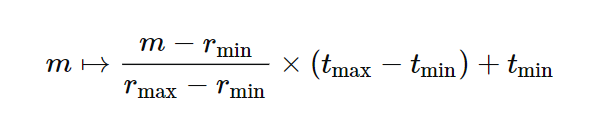

## Training and Testing using Start CNN Representations

In [ ]:
# Loading starting layer CNN representations
import numpy as np
#Guassian pyramid is used to perform downsampling of start CNN representations from (112*112*64) to (14*14*64)
from skimage.transform import pyramid_gaussian

# Applying guassian pyramid and getting downsampled CNN start representations
train_fin = []
for i in st_arr:
  pyramid = tuple(pyramid_gaussian(i, downscale=2, channel_axis=-1))
  train_fin.append(np.array(pyramid[3]))

In [8]:
#Function to normalise CNN representations to prepare for input into the model
def normalise_rep(rep):
  rep = rep.flatten()
  mi = np.min(rep)
  ma = np.max(rep)
  tma = 255
  tmi = 0
  rep = (((rep - mi)/(ma - mi)) * (tma-tmi)) + tmi
  return rep.reshape((112,112))

In [9]:
# Normalizing the CNN values
inp_states = [normalise_rep(i) for i in train_fin]

In [ ]:
# Training the Hopfield using the Starting CNN Representations
hopfield_network = ClassicalHopfield(input_shape = (224,112))
assert len(train_fin) <= hopfield_network.storage_capacity_limit() # best to keep number of patterns below storage capacity
energy_list = [0]
jj=0
for pattern in inp_states:
    jj+=1
    print(jj)
    states = hopfield_network.process_image(Image.fromarray(pattern))
    hopfield_network.train(states)
    energy_list.append(hopfield_network.energy_function(states))

plt.plot([i for i in range(len(energy_list))], energy_list)
plt.xlabel("Patterns Trained")
plt.ylabel("Energy")
plt.show()

In [24]:
#Deleting the variables not required to free up space
del train_fin
del inp_states

In [ ]:
# Using test paths, we find start CNN representations, downsample them using Gaussian Pyramids, normalize them
# Then apply model preprocessor, corrupt using noise and finally test for accuracy and store the results
from skimage.transform import pyramid_gaussian
test_img_info_1 = test_img_info.copy()
for i, new_path in enumerate(new_test_img_paths):
    img = image.load_img(new_path, target_size=(224, 224))
    x= image.img_to_array(img)
    x= np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pat = model_st.predict(x)
    pyramid = tuple(pyramid_gaussian(pat, downscale=2, channel_axis=-1))
    pat = np.array(pyramid[3])
    pattern = normalise_rep(pat)
    states = hopfield_network.process_image(Image.fromarray(pattern))
    mask = list(np.random.permutation(np.arange(0,112*112*64))[:125])
    corrupted_states = states.copy()
    for pp in mask:
      corrupted_states[pp] *= -1
    predicted_states = corrupted_states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(predicted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states))*100 / np.prod(states.size)
    test_img_info_1[test_img_info_1[1] == new_path.split('/')[-2]].append(acc)
    print(i)

In [63]:
# Storing the results into excel sheets
start_rep_result = pd.DataFrame(test_img_info_1)
start_rep_result.to_excel("start_rep_result.xlsx")

## Training and Testing using End CNN Representations

In [ ]:
# Loading ending layer CNN representations
import numpy as np
#Guassian pyramid is used to perform downsampling of end CNN representations from (7*7*512) to (7*7*512)
from skimage.transform import pyramid_gaussian

# Applying guassian pyramid and getting downsampled CNN end representations
train_fin = []
for i in fin_arr:
  pyramid = tuple(pyramid_gaussian(i, downscale=2, channel_axis=-1))
  train_fin.append(np.array(pyramid[0]))

In [ ]:
#Function to normalise CNN representations to prepare for input into the model
def normalise_rep(rep):
  rep = rep.flatten()
  mi = np.min(rep)
  ma = np.max(rep)
  tma = 255
  tmi = 0
  rep = (((rep - mi)/(ma - mi)) * (tma-tmi)) + tmi
  return rep.reshape((224,112))

In [ ]:
# Normalizing the CNN values
inp_states = [normalise_rep(i) for i in train_fin]

In [ ]:
# Training the Hopfield using the ending CNN Representations
hopfield_network = ClassicalHopfield(input_shape = (224,112))
assert len(train_fin) <= hopfield_network.storage_capacity_limit() # best to keep number of patterns below storage capacity
energy_list = [0]
jj=0
for pattern in inp_states:
    jj+=1
    print(jj)
    states = hopfield_network.process_image(Image.fromarray(pattern))
    hopfield_network.train(states)
    energy_list.append(hopfield_network.energy_function(states))

plt.plot([i for i in range(len(energy_list))], energy_list)
plt.xlabel("Patterns Trained")
plt.ylabel("Energy")
plt.show()

In [ ]:
#Deleting the variables not required to free up space
del train_fin
del inp_states

In [ ]:
# Using test paths from previous sections, we find end CNN representations, downsample them using Gaussian Pyramids,
# normalize them, then apply model preprocessor, corrupt using noise and finally test for accuracy and store the results
from skimage.transform import pyramid_gaussian
test_img_info_2 = test_img_info.copy()
for i, new_path in enumerate(new_test_img_paths):
    img = image.load_img(new_path, target_size=(224, 224))
    x= image.img_to_array(img)
    x= np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pat = model_st.predict(x)
    pyramid = tuple(pyramid_gaussian(pat, downscale=2, channel_axis=-1))
    pat = np.array(pyramid[0])
    pattern = normalise_rep(pat)
    states = hopfield_network.process_image(Image.fromarray(pattern))
    mask = list(np.random.permutation(np.arange(0,7*7*512))[:250])
    corrupted_states = states.copy()
    for pp in mask:
      corrupted_states[pp] *= -1
    predicted_states = corrupted_states.copy()
    energy_list = [hopfield_network.energy_function(predicted_states)]
    predicted_states = hopfield_network.test(predicted_states, synchronous = True)
    acc = np.sum(np.asarray(states) == np.asarray(predicted_states))*100 / np.prod(states.size)
    test_img_info_2[test_img_info_2[1] == new_path.split('/')[-2]].append(acc)
    print(i)

In [ ]:
# Storing the results into excel sheets
end_rep_result = pd.DataFrame(test_img_info_2)
end_rep_result.to_excel("end_rep_result.xlsx")

## Getting all results to single DataFrame and then binning the data

In [11]:
# Loading similarity data into memory from file
import pandas as pd
sim_cat_dat = pd.read_csv("/content/drive/MyDrive/category_similarity.csv")

In [21]:
# Getting actual positions of similarity dataset to insert accuracies into based on category name match
new_test_img_cats = [k.split('/')[-2] for k in new_test_img_paths]

In [27]:
# Putting all results into two lists one for start representation accuracy and other for end representation accuracy
final_result_start_repr_cat = []
final_result_end_repr_cat = []
for cat_cat in list(sim_cat_dat['Category Name']):
  pos = new_test_img_cats.index(cat_cat)
  final_result_start_repr_cat.append(test_img_info_1[0][-1][pos])
  final_result_end_repr_cat.append(test_img_info_2[0][-1][pos])

In [28]:
# Adding the start and end representation accuracy columns to the main dataset
sim_cat_dat['Acc_Start'] = pd.Series(start_rep_result[''])
sim_cat_dat['Acc_End'] = pd.Series(final_result_end_repr_cat)

In [29]:
sim_cat_dat

,Category Name,Start Sim,Mid Sim,End Sim,Path,Acc_Start,Acc_End
0,rollingpin,0.812470,0.583735,0.515097,/content/drive/MyDrive/ObjectCategories2/4-obj...,94.021046,99.525670
1,servingpiece,0.761342,0.456306,0.366598,/content/drive/MyDrive/ObjectCategories2/4-obj...,93.255740,99.178890
2,spicerack,0.547922,0.364385,0.364846,/content/drive/MyDrive/ObjectCategories2/4-obj...,89.022640,99.198820
3,wheelbarrow,0.598456,0.391241,0.447747,/content/drive/MyDrive/ObjectCategories2/4-obj...,92.259247,99.469866
4,window,0.745731,0.373921,0.335546,/content/drive/MyDrive/ObjectCategories2/4-obj...,95.065370,99.473852
...,...,...,...,...,...,...,...
155,feather,0.755710,0.403659,0.322031,/content/drive/MyDrive/ObjectCategories2/16-ob...,93.726084,99.541614
156,coffeemaker,0.568002,0.364612,0.314367,/content/drive/MyDrive/ObjectCategories2/16-ob...,89.277742,99.031409
157,birdhouse,0.662840,0.333801,0.285871,/content/drive/MyDrive/ObjectCategories2/16-ob...,89.325574,98.955676
158,carabiners,0.687590,0.509880,0.578377,/content/drive/MyDrive/ObjectCategories2/16-ob...,91.326531,99.641263


In [30]:
# Splitting the main dataset into three sub datasets one for each layer similarity
st_sim_df = sim_cat_dat[['Category Name','Start Sim','Path','Acc_Start','Acc_End']]
md_sim_df = sim_cat_dat[['Category Name','Mid  Sim', 'Path','Acc_Start','Acc_End']]
fin_sim_df = sim_cat_dat[['Category Name','End Sim', 'Path','Acc_Start','Acc_End']]

In [31]:
# Sorting datasets based on similarity
st_sim_df_sort  = st_sim_df.sort_values(by=['Start Sim'])
md_sim_df_sort  = md_sim_df.sort_values(by=['Mid  Sim'])
fin_sim_df_sort = fin_sim_df.sort_values(by=['End Sim'])

In [32]:
# Function to get number of objects in the category
def get_obj_num(inp):
  return inp.split('/')[-2]

In [33]:
# Adding object info to the datasets
st_sim_df_sort['Obj Num']  =  st_sim_df_sort['Path'].apply(get_obj_num)
md_sim_df_sort['Obj Num']  =  md_sim_df_sort['Path'].apply(get_obj_num)
fin_sim_df_sort['Obj Num'] = fin_sim_df_sort['Path'].apply(get_obj_num)

st_sim_df_sort.reset_index(inplace=True)
md_sim_df_sort.reset_index(inplace=True)
fin_sim_df_sort.reset_index(inplace=True)

In [34]:
# Binning each layer dataset into 3 different bins based on similarity score of that category
# Similarity : Bin 1 < Bin 2 < Bin 3
# Bin1  = 53 categories, Bin 2 = 54 Categories, Bin 3 = 53 Categories

st_bin1  = st_sim_df_sort.iloc[:53].copy()
st_bin2  = st_sim_df_sort.iloc[53:107].copy()
st_bin3  = st_sim_df_sort.iloc[107:160].copy()
md_bin1  = md_sim_df_sort.iloc[:53].copy()
md_bin2  = md_sim_df_sort.iloc[53:107].copy()
md_bin3  = md_sim_df_sort.iloc[107:160].copy()
fin_bin1 = fin_sim_df_sort.iloc[:53].copy()
fin_bin2 = fin_sim_df_sort.iloc[53:107].copy()
fin_bin3 = fin_sim_df_sort.iloc[107:160].copy()

In [35]:
# Making a table to show how many categories of particuar number of exemplars/objects are in each bin

obj_count_df = pd.DataFrame([st_bin1['Obj Num'].value_counts(),st_bin2['Obj Num'].value_counts(),st_bin3['Obj Num'].value_counts(),md_bin1['Obj Num'].value_counts(),md_bin2['Obj Num'].value_counts(), md_bin3['Obj Num'].value_counts(),fin_bin1['Obj Num'].value_counts(),fin_bin2['Obj Num'].value_counts(),fin_bin3['Obj Num'].value_counts()]).reset_index()
obj_count_df = obj_count_df.loc[:, obj_count_df.columns != 'index']
obj_count_df.rename(index={0:'Start Bin 1',1:'Start Bin 2',2:'Start Bin 3',3:'Mid Bin 1',4:'Mid Bin 2',5:'Mid Bin 3',6:'End Bin 1',7:'End Bin 2',8:'End Bin 3'})

,8-objects,4-objects,2-objects,16-objects
Start Bin 1,16,13,12,12
Start Bin 2,13,13,11,17
Start Bin 3,11,14,17,11
Mid Bin 1,16,11,8,18
Mid Bin 2,12,16,13,13
Mid Bin 3,12,13,19,9
End Bin 1,15,12,11,15
End Bin 2,16,17,7,14
End Bin 3,9,11,22,11


In [ ]:
# Writing object/exemplar count data to file
obj_count_df.to_csv("/content/drive/MyDrive/bin_object_count.csv")

In [36]:
# Writing all the resulting binned datasets to excel file for further processing

st_bin1.to_excel('/content/drive/MyDrive/st_bin1_res.xlsx')
st_bin2.to_excel('/content/drive/MyDrive/st_bin2_res.xlsx')
st_bin3.to_excel('/content/drive/MyDrive/st_bin3_res.xlsx')
md_bin1.to_excel('/content/drive/MyDrive/md_bin1_res.xlsx')
md_bin2.to_excel('/content/drive/MyDrive/md_bin2_res.xlsx')
md_bin3.to_excel('/content/drive/MyDrive/md_bin3_res.xlsx')
fin_bin1.to_excel('/content/drive/MyDrive/fin_bin1_res.xlsx')
fin_bin2.to_excel('/content/drive/MyDrive/fin_bin2_res.xlsx')
fin_bin3.to_excel('/content/drive/MyDrive/fin_bin3_res.xlsx')